In [2]:
import numpy as np
import pandas as pd

import datetime
import time

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

from keras import backend as K
from keras.layers import (Input, Activation, Dense, Lambda, Layer, 
                          add, multiply)
from keras.models import Model, Sequential
from keras.callbacks import TerminateOnNaN
from keras.datasets import mnist

from tqdm import tnrange

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions



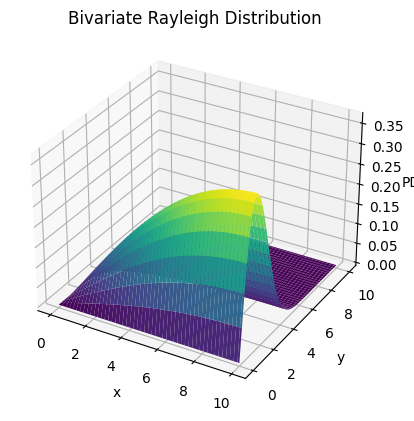

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def bivariate_rayleigh_pdf(x, y, sigma_x, sigma_y):
    """
    Compute the PDF of a bivariate Rayleigh distribution.

    Arguments:
    - x: Array of x values.
    - y: Array of y values.
    - sigma_x: Scale parameter in the x-direction.
    - sigma_y: Scale parameter in the y-direction.

    Returns:
    - pdf: Array of PDF values corresponding to each (x, y) pair.
    """
    pdf = (x * y) / (sigma_x * sigma_y) * np.exp(-(x**2 / (2 * sigma_x**2)) - (y**2 / (2 * sigma_y**2)))
    return pdf

# Generate x and y values
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)

# Parameters
sigma_x = 10.0
sigma_y = 1.5

# Compute PDF
pdf = bivariate_rayleigh_pdf(X, Y, sigma_x, sigma_y)

# Plot PDF
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, pdf, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Bivariate Rayleigh Distribution')
plt.show()


**Plotting Distribution**

In [5]:
sigma1 = 1.0
sigma2 = 3.5

q = np.random.rayleigh(sigma1, size=800)
p = np.random.rayleigh(sigma2, size=800)

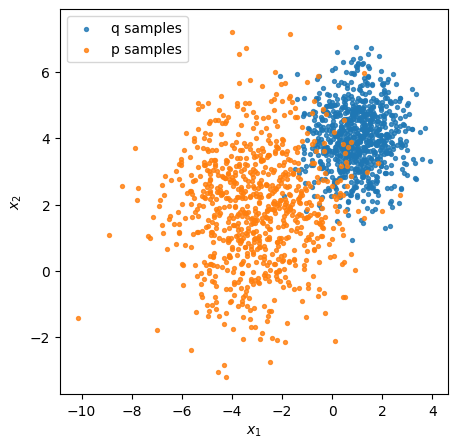

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(q[:,0],q[:,1],s=8,alpha=.8, label='q samples')
ax.scatter(p[:,0],p[:,1],s=8,alpha=.8, label='p samples')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend()

plt.show()

### **KL DIvergence using simplified form**

In [ ]:
def kl_mvn(m0, S0, m1, S1):
    """
    Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
    Also computes KL divergence from a single Gaussian pm,pv to a set
    of Gaussians qm,qv.
    

    From wikipedia
    KL( (m0, S0) || (m1, S1))
         = .5 * ( tr(S1^{-1} S0) + log |S1|/|S0| + 
                  (m1 - m0)^T S1^{-1} (m1 - m0) - N )
    """
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    iS1 = np.linalg.inv(S1)
    diff = m1 - m0

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N) 

In [ ]:
q_cov    = np.array([[1, 0],[0, 1]])
q_mean   = np.array([1 ,  4])

p_cov    = np.array([[3, 0],[0, 3]])
p_mean   = np.array([-3 , 2])

q_mean = np.reshape(q_mean, (2,1))
p_mean = np.reshape(p_mean, (2,1))

#timing the execution
st = datetime.datetime.now()
x = kl_mvn(q_mean, q_cov, p_mean, p_cov)
et = datetime.datetime.now()

kl_true = np.sum(x)
elapsed_time = et - st
cl_sol = elapsed_time
print('Execution time:', elapsed_time, 'seconds')
print(kl_true)

Execution time: 0:00:00.002443 seconds
3.765278955334776


### **Using scipy package**

In [ ]:
import numpy as np

def KLdivergence(x, y):
  """Compute the Kullback-Leibler divergence between two multivariate samples.
  Parameters
  ----------
  x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
  y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
  Returns
  -------
  out : float
    The estimated Kullback-Leibler divergence D(P||Q).
  References
  ----------
  Pérez-Cruz, F. Kullback-Leibler divergence estimation of
continuous distributions IEEE International Symposium on Information
Theory, 2008.
  """
  from scipy.spatial import cKDTree as KDTree

  # Check the dimensions are consistent
  x = np.atleast_2d(x)
  y = np.atleast_2d(y)

  n,d = x.shape
  m,dy = y.shape

  assert(d == dy)


  # Build a KD tree representation of the samples and find the nearest neighbour
  # of each point in x.
  xtree = KDTree(x)
  ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
  r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
  s = ytree.query(x, k=1, eps=.01, p=2)[0]

  # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
  # on the first term of the right hand side.
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

st = datetime.datetime.now()
x = KLdivergence(q,p)
et = datetime.datetime.now()
elapsed_time = et - st
est_sol = elapsed_time
print('Execution time:', elapsed_time, 'seconds')
print(x)
accuracyest = (x)*100/kl_true

Execution time: 0:00:00.007937 seconds
3.548564163225686


**What should entropy be?**

In [ ]:
from scipy.stats import multivariate_normal
q_cov    = np.array([[1, 0],[0, 1]])
q_mean   = np.array([1 ,  4])

p_cov    = np.array([[3, 0],[0, 3]])
p_mean   = np.array([-3 , 2])

entrpy = multivariate_normal(mean=q_mean, cov=q_cov).entropy()
print(entrpy)

2.8378770664093453


### **KL Divergence done by me the goat**

In [ ]:
q_cov    = np.array([[1, 0],[0, 1]])
q_mean   = np.array([1 , 4])

p_cov    = np.array([[3, 0],[0, 3]])
p_mean   = np.array([-3 , 2])

3.7582420791574656 !!!!!



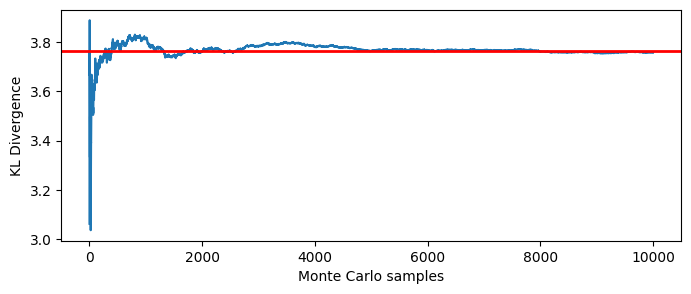

In [ ]:
#find the entropy and cross entropy
no_samp = 10000
cummean_out1 = np.array([0])
entropy_MC = np.array([0])
crossentropy_MC = np.array([0])
for i in range(no_samp):
    
    #formatting the data
    q_cov    = np.array([[1, 0],[0, 1]])
    q_mean   = np.array([1 , 4])
    p_cov    = np.array([[3, 0],[0, 3]])
    p_mean   = np.array([-3 ,2])
    z = np.random.multivariate_normal(q_mean, q_cov)
    z = np.column_stack([z])
    q_mean = np.reshape(q_mean, (2,1))
    p_mean = np.reshape(p_mean, (2,1))
    
    #calcualte the entropy 
    entropy = 0.5*np.dot(np.dot(np.transpose(z - q_mean),np.linalg.inv(q_cov)),(z - q_mean))
    entropy_MC = np.vstack((entropy_MC,np.sum(entropy)))

    #calculate the cross entropy
    crossentropy = 0.5*np.dot(np.dot(np.transpose(z - p_mean),np.linalg.inv(p_cov)),(z - p_mean))
    crossentropy_MC = np.vstack((crossentropy_MC,np.sum(crossentropy)))

    output1 = entropy_MC.mean() 
    output2 = crossentropy_MC.mean() 
    finalentropy_MC = 0.5*np.log(np.linalg.det(q_cov)) + 2*0.5*np.log(2*np.pi) + output1
    finalcrossentropy_MC = 0.5*np.log(np.linalg.det(p_cov)) + 2*0.5*np.log(2*np.pi) + output2
    cummean_out1 = np.vstack((cummean_out1, finalcrossentropy_MC - finalentropy_MC))
   
output1 = entropy_MC.mean() 
output2 = crossentropy_MC.mean()

finalentropy_MC = 0.5*np.log(np.linalg.det(q_cov)) + 2*0.5*np.log(2*np.pi) + output1
finalcrossentropy_MC = 0.5*np.log(np.linalg.det(p_cov)) + 2*0.5*np.log(2*np.pi) + output2

print(finalcrossentropy_MC - finalentropy_MC,'!!!!!\n')
accuracy10000 = (finalcrossentropy_MC - finalentropy_MC)*100/kl_true

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(cummean_out1[2:])
ax.axhline(y=kl_true, color='r', linewidth=2., label='True')
ax.set_xlabel('Monte Carlo samples')
ax.set_ylabel('KL Divergence')
#ax.set_ylim(.95*kl_true, 1.05*kl_true)
plt.show()

3.6633713612991974 !!!!!



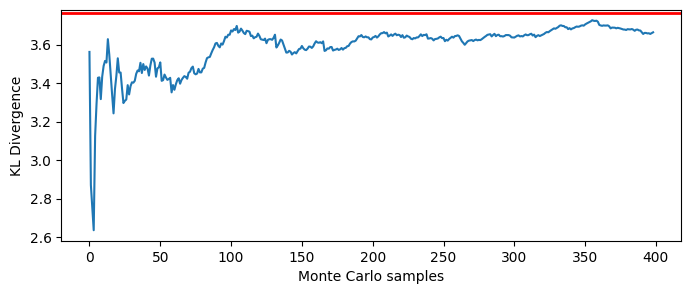

In [ ]:
#find the entropy and cross entropy
no_samp = 400
cummean_out2 = np.array([0])
entropy_MC = np.array([0])
crossentropy_MC = np.array([0])
for i in range(no_samp):
    
    #formatting the data
    q_cov    = np.array([[1, 0],[0, 1]])
    q_mean   = np.array([1 ,  4])
    p_cov    = np.array([[3, 0],[0, 3]])
    p_mean   = np.array([-3 , 2])
    z = np.random.multivariate_normal(q_mean, q_cov)
    z = np.column_stack([z])
    q_mean = np.reshape(q_mean, (2,1))
    p_mean = np.reshape(p_mean, (2,1))
    
    #calcualte the entropy 
    entropy = 0.5*np.dot(np.dot(np.transpose(z - q_mean),np.linalg.inv(q_cov)),(z - q_mean))
    entropy_MC = np.vstack((entropy_MC,np.sum(entropy)))

    #calculate the cross entropy
    crossentropy = 0.5*np.dot(np.dot(np.transpose(z - p_mean),np.linalg.inv(p_cov)),(z - p_mean))
    crossentropy_MC = np.vstack((crossentropy_MC,np.sum(crossentropy)))

    output1 = entropy_MC.mean() 
    output2 = crossentropy_MC.mean() 
    finalentropy_MC = 0.5*np.log(np.linalg.det(q_cov)) + 2*0.5*np.log(2*np.pi) + output1
    finalcrossentropy_MC = 0.5*np.log(np.linalg.det(p_cov)) + 2*0.5*np.log(2*np.pi) + output2
    cummean_out2 = np.vstack((cummean_out2, finalcrossentropy_MC - finalentropy_MC))
   
output1 = entropy_MC.mean() 
output2 = crossentropy_MC.mean()

finalentropy_MC = 0.5*np.log(np.linalg.det(q_cov)) + 2*0.5*np.log(2*np.pi) + output1
finalcrossentropy_MC = 0.5*np.log(np.linalg.det(p_cov)) + 2*0.5*np.log(2*np.pi) + output2

print(finalcrossentropy_MC - finalentropy_MC,'!!!!!\n')
accuracy400 = (finalcrossentropy_MC - finalentropy_MC)*100/kl_true

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(cummean_out2[2:])
ax.axhline(y=kl_true, color='r', linewidth=2., label='True')
ax.set_xlabel('Monte Carlo samples')
ax.set_ylabel('KL Divergence')
#ax.set_ylim(.95*kl_true, 1.05*kl_true)
plt.show()

### **Comparing different no. samples**

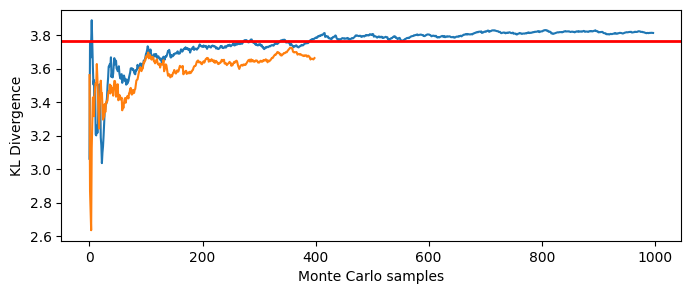

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(cummean_out1[2:1000])
ax.plot(cummean_out2[2:1000])
ax.axhline(y=kl_true, color='r', linewidth=2., label='True')
ax.set_xlabel('Monte Carlo samples')
ax.set_ylabel('KL Divergence')
#ax.set_ylim(.95*kl_true, 1.05*kl_true)
plt.show()

### **Timing**

In [ ]:
#find the entropy and cross entropy
no_samp = 100
cummean_out = np.array([0])
entropy_MC = np.array([0])
crossentropy_MC = np.array([0])
p_cov    = np.array([[3, 0],[0, 3]])
p_mean   = np.array([-3 , 2])

#timing the execution
st = datetime.datetime.now()
for i in range(no_samp):
    
    #formatting the data
    q_cov    = np.array([[1, 0],[0, 1]])
    q_mean   = np.array([1 ,  4])
    
    z = np.random.multivariate_normal(q_mean, q_cov)
    z = np.column_stack([z])
    q_mean = np.reshape(q_mean, (2,1))
    p_mean = np.reshape(p_mean, (2,1))
    
    #calcualte the entropy 
    entropy = 0.5*np.dot(np.dot(np.transpose(z - q_mean),np.linalg.inv(q_cov)),(z - q_mean))
    entropy_MC = np.vstack((entropy_MC,np.sum(entropy)))

    #calculate the cross entropy
    crossentropy = 0.5*np.dot(np.dot(np.transpose(z - p_mean),np.linalg.inv(p_cov)),(z - p_mean))
    crossentropy_MC = np.vstack((crossentropy_MC,np.sum(crossentropy)))
   
output1 = entropy_MC.mean() 
output2 = crossentropy_MC.mean()

finalentropy_MC = 0.5*np.log(np.linalg.det(q_cov)) + 2*0.5*np.log(2*np.pi) + output1
finalcrossentropy_MC = 0.5*np.log(np.linalg.det(p_cov)) + 2*0.5*np.log(2*np.pi) + output2

et = datetime.datetime.now()
elapsed_time_100 = et - st
print('Execution time for 400 iterations:', elapsed_time_100, 'seconds')

#find the entropy and cross entropy
no_samp = 10000
cummean_out = np.array([0])
entropy_MC = np.array([0])
crossentropy_MC = np.array([0])
p_cov    = np.array([[3, 0],[0, 3]])
p_mean   = np.array([-3 , 2])

#timing the execution
st = datetime.datetime.now()
for i in range(no_samp):
    
    #formatting the data
    q_cov    = np.array([[1, 0],[0, 1]])
    q_mean   = np.array([1 ,  4])
    
    z = np.random.multivariate_normal(q_mean, q_cov)
    z = np.column_stack([z])
    q_mean = np.reshape(q_mean, (2,1))
    p_mean = np.reshape(p_mean, (2,1))
    
    #calcualte the entropy 
    entropy = 0.5*np.dot(np.dot(np.transpose(z - q_mean),np.linalg.inv(q_cov)),(z - q_mean))
    entropy_MC = np.vstack((entropy_MC,np.sum(entropy)))

    #calculate the cross entropy
    crossentropy = 0.5*np.dot(np.dot(np.transpose(z - p_mean),np.linalg.inv(p_cov)),(z - p_mean))
    crossentropy_MC = np.vstack((crossentropy_MC,np.sum(crossentropy)))
   
output1 = entropy_MC.mean() 
output2 = crossentropy_MC.mean()

finalentropy_MC = 0.5*np.log(np.linalg.det(q_cov)) + 2*0.5*np.log(2*np.pi) + output1
finalcrossentropy_MC = 0.5*np.log(np.linalg.det(p_cov)) + 2*0.5*np.log(2*np.pi) + output2

et = datetime.datetime.now()
elapsed_time_10000 = et - st
print('Execution time for 10000 iterations:', elapsed_time_10000, 'seconds')
print('Execution time for closed form solution:', cl_sol, 'seconds')
print('Execution time for estimation:', est_sol, 'seconds')

Execution time for 400 iterations: 0:00:00.021538 seconds
Execution time for 10000 iterations: 0:00:03.541117 seconds
Execution time for closed form solution: 0:00:00.002443 seconds
Execution time for estimation: 0:00:00.007937 seconds


### **Summarizing results**

In [ ]:
print(elapsed_time_100.total_seconds())

0.021538


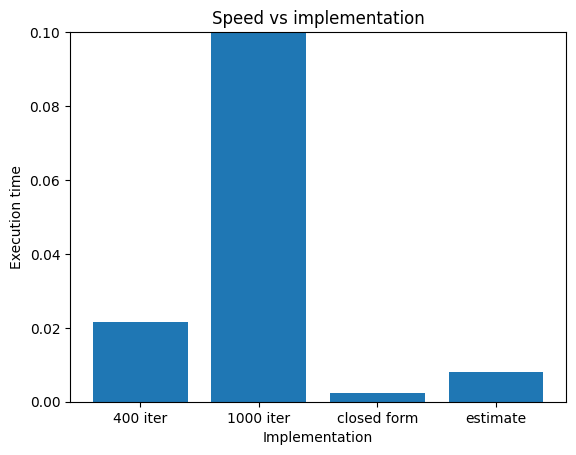

In [ ]:
import matplotlib.pyplot as plt

x_axis = ['400 iter', '1000 iter', 'closed form', 'estimate']
y_axis = [elapsed_time_100.total_seconds(), elapsed_time_10000.total_seconds(), cl_sol.total_seconds(), est_sol.total_seconds()]

ax = plt.gca()
ax.set_ylim([0, 0.1])
plt.bar(x_axis, y_axis)
plt.title('Speed vs implementation')
plt.xlabel('Implementation')
plt.ylabel('Execution time')
plt.show()

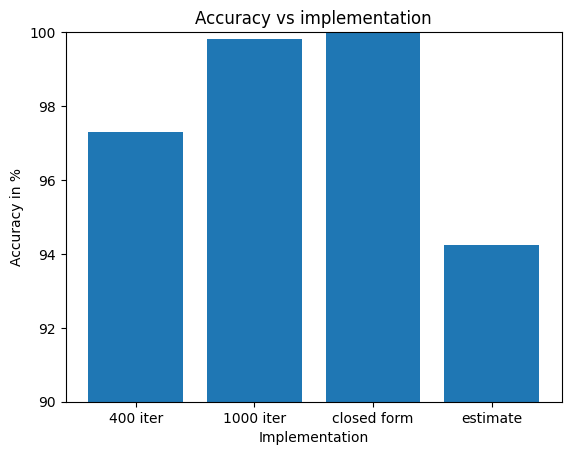

In [ ]:
import matplotlib.pyplot as plt

x_axis = ['400 iter', '1000 iter', 'closed form', 'estimate']
y_axis = [accuracy400, accuracy10000, 100, accuracyest]

ax = plt.gca()
ax.set_ylim([90, 100])

plt.bar(x_axis, y_axis)
plt.title('Accuracy vs implementation')
plt.xlabel('Implementation')
plt.ylabel('Accuracy in %')
plt.show()